In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar
from numerize import numerize
import plotly.graph_objects as go
import plotly.express as px
from ipywidgets import interact, widgets

In [18]:
def cleanData(dataSet: pd.DataFrame) -> pd.DataFrame:
    """
    This function is used to clean the data by replacing few keys using 'mapper.csv' 
    and make it consistent for further processing.
    :param dataSet: Dataframe to be cleaned
    :return: Dataframe with appropriate transformations.
    """
    dataSet_copy = dataSet.copy()
    mapper = pd.read_csv('mapper.csv')
    dataSet_copy['State'].replace(to_replace = mapper.to_replace.tolist(),
        value = mapper.value.tolist(), inplace = True)

    return dataSet_copy

In [19]:
def getStateGovernments(stateElect: pd.DataFrame) -> pd.DataFrame:
    """
    This function aims to find the Ruling Party in each state and the votes it received.
    :param stateElect: Dataframe with election data
    :return: Dataframe with states and the corresponding political party in power.
    """
    groupByStateParty = stateElect.groupby(['State', 'Party']).agg({'Votes': 'sum'})
    groupByStateParty.columns = ['Votes']
    groupByStateParty = groupByStateParty.reset_index()

    stateRulingParty = groupByStateParty.sort_values(['Votes'], ascending=False)
    stateRulingParty = stateRulingParty.drop_duplicates(subset=['State'], keep='first')

    return stateRulingParty

In [20]:
def getStateVaccineRecords(stateVaccines: pd.DataFrame) -> pd.DataFrame:
    """
    This function is used to find the vaccine data for each state based on the latest updated date.
    :param stateVaccines: Dataframe with vaccine data statewise
    :return: Dataframe with sates and corresponding number of individuals vaccinated as per latest updated date.
    """
    stateVaccines = stateVaccines.loc[stateVaccines['State'] != 'India']
    stateVaccine = stateVaccines.copy()
    stateVaccine['Updated On'] = pd.to_datetime(stateVaccine['Updated On'], infer_datetime_format=True)
    latestVaccineInfo = stateVaccine.sort_values(['Updated On'], ascending=False)
    latestVaccineInfo = latestVaccineInfo.drop_duplicates(subset=['State'], keep='first')
    latestVaccineInfo = latestVaccineInfo.reset_index()
    return latestVaccineInfo

In [21]:
def calcVaccinationRate(Total_Individuals_Vaccinated: float, Population_2019: float) -> float:
    """
    The purpose of this function is to calculate the VaccineRate in each state by finding the ratio of Total Individuals Vaccinated and Population.
    :param Total_Individuals_Vaccinated: Number of individuals vaccinated
    :param Population_2019: Population of the state
    :return: VaccineRate(float)
    """
    VaccinationRate = (Total_Individuals_Vaccinated / Population_2019) * 100
    return VaccinationRate

In [22]:
def calcRateOfVaccination(vaccineRecords: pd.DataFrame, statePop: pd.DataFrame,
                          stateGovernments: pd.DataFrame) :
    """
    This function is used to calculate the VaccineRate and add it as a new column in the dataframe.
    :param vaccineRecords: Vaccine data
    :param statePop: Population data
    :param stateGovernments: Election data
    :return: Tuple with two dataframes consisting of vaccination rates.
    """
    vaccinePopulation = statePop[['State', 'Population_2019']].merge(
                        vaccineRecords[['Updated On', 'State', 'Total Individuals Vaccinated']], on='State')
    vaccinePopulation['VaccinationRate'] = vaccinePopulation.apply(
        lambda row: calcVaccinationRate(row['Total Individuals Vaccinated'], row['Population_2019']), axis=1)

    vaccinePopulation1 = statePop[['State', 'Population_2019']].merge(
                         vaccineRecords[['Updated On', 'State', 'Total Individuals Vaccinated']], on='State').merge(
                         stateGovernments[['State', 'Party']], on='State')

    grouped = vaccinePopulation1.groupby('Party').agg({'Population_2019': 'sum', 'Total Individuals Vaccinated': 'sum'})
    grouped = grouped.reset_index()
    grouped['VaccinationRate'] = grouped.apply(
        lambda row: calcVaccinationRate(row['Total Individuals Vaccinated'], row['Population_2019']), axis=1)

    return (grouped, vaccinePopulation)

In [23]:
def stateClassificationByRulingParty(stateGovernments: pd.DataFrame, rateOfVaccination: pd.DataFrame) -> pd.DataFrame:
    """
    This function aims at merging the election dataframe and VaccineRate dataframe for further processing.
    :param stateGovernments: Election data
    :param rateOfVaccination: VaccineRate data
    :return: Dataframe with states classified based on the currently ruling party.
    """
    vaccinationRate_by_rulingParty = stateGovernments[['State', 'Party']].merge(
        rateOfVaccination[['State', 'Population_2019', 'Total Individuals Vaccinated', 'VaccinationRate']], on='State')
    return vaccinationRate_by_rulingParty

In [24]:
def hypothesis1(electionData, vaccineData, populationData):
    """
    This function consists of all the steps required for Hypothesis 1. 
    All the function calls for Hypothesis 1 are made from this function.
    :param electionData: Dataframe with results for 2019 elections in India.
    :param vaccineData: Dataframe with vaccination records for each state in India.
    :param populationData: Dataframe with population in each state as of 2019.   
    """
    
    print("#########################################################################################################")
    print("                                            HYPOTHESIS 1                                                 ")
    print("#########################################################################################################")
    
    # Fetching the currently ruling parties in each state of India.
    stateGovernments = getStateGovernments(electionData)

    # Fetching the statewise vaccination records for the latest dates.
    stateVaccineRecords = getStateVaccineRecords(vaccineData)

    # Calculating the rate of vaccination in each state.
    rateOfVaccination_vs_party = calcRateOfVaccination(stateVaccineRecords, populationData, stateGovernments)

    # Plotting bar plot for States within each party vs vaccination rate.
    drp_dwn = widgets.Dropdown(value = 'Total Individuals Vaccinated', 
                           options = [('# vaccinated', 'Total Individuals Vaccinated'),
                                      ('% vaccinated', 'VaccinationRate')])
    @interact(y = drp_dwn)
    def plot(y):
        
        fig = px.bar(rateOfVaccination_vs_party[0], x = 'Party', y = y, log_y = True, title = 'Vaccination per Political Party',
                    hover_name = 'Party',
                    hover_data = {'a': [numerize.numerize(x, 0) for x in
                                        rateOfVaccination_vs_party[0].Population_2019.tolist()],
                                 'tiv': [numerize.numerize(x, 0) for x in
                                        rateOfVaccination_vs_party[0]['Total Individuals Vaccinated'].tolist()],
                                 'vr': [round(x, 2) for x in 
                                        rateOfVaccination_vs_party[0]['VaccinationRate'].tolist()], 
                                 y: False,
                                 'VaccinationRate': False,
                                 'Party': False,
                                 'Population_2019': False}, 
                    labels = {'a': 'population',
                              'tiv': '# vaccinated',
                            'vr': '% vaccinated'},
                    color = 'Population_2019',
                    color_continuous_scale = 'darkmint')
        fig.update_layout(plot_bgcolor = 'white')
        fig.show()

    # Classifying the states by ruling parties.
    vaccinationRate_by_rulingParty = stateClassificationByRulingParty(stateGovernments, rateOfVaccination_vs_party[1])

    # plotting bar bar graph for States vs Vaccination rate and coloring the bar plot to represent the ruling party.
    fig, ax = plt.subplots(figsize=(100, 30))
    for key, grp in vaccinationRate_by_rulingParty.groupby(['Party']):
        ax.bar(grp['State'], grp['VaccinationRate'], label=key)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(55)
    ax.legend(loc=2, prop={'size': 40})
    ax.tick_params(axis='x', labelrotation=90)
    plt.title(label="States Vs Vaccination Rates",
              fontsize=95)
    plt.xlabel('States', fontsize=55)
    plt.ylabel('Vaccination Rates', fontsize=55)
    plt.show()
    
    return stateGovernments

In [25]:
def getTestGrouped(testData: pd.DataFrame)-> pd.DataFrame:
    """
    Combines number of tests conducted and positive cases for each day recorded in dataset for every state.
    :param testData: Data frame consisting of the COVID-19 testing data for each state.
    :return: Creates a dataframe having total number of tests conducted and positive cases for each day recorded in 
    India.
    """
    testingTotal = testData.groupby(['Updated On']).agg({'Total Tested': 'sum'})
    testingTotal = testingTotal.reset_index()
    
    testingPositive = testData.groupby(['Updated On']).agg({'Positive': 'sum'})
    testingPositive = testingPositive.reset_index()
    
    testGrouped = testingTotal.merge(testingPositive, on='Updated On')
    
    return testGrouped

In [26]:
def getTotalDailyVaccinated(vaccination: pd.DataFrame)-> pd.DataFrame:
    """
    Combines number of individuals vaccinated for each day across all the states.
    :param vaccination: Dataframe consisting of vaccination records for each state.
    :return: Dataframe having total number of individuals vaccinated for each day recorded.
    """
    vaccination_ = vaccination.copy()
    vaccination_['Updated On'] = pd.to_datetime(vaccination_['Updated On'], infer_datetime_format=True)
    vaccineCombined = vaccination_.groupby(['Updated On']).agg({'Total Individuals Vaccinated': 'sum'})
    vaccineCombined = vaccineCombined.reset_index()
    
    return vaccineCombined

In [27]:
def plotHypo2(testingVsVaccinated: pd.DataFrame, title: str):
    '''
    This functions creates all the three plots required for the hypothesis 2.
    :param testingVsVaccinated: Dataframe consisting of testing and vaccination details for each date across different states.
    :param title: String which is used as title of the plots.
    '''
    fig = go.Figure()
    
    if "before" in title:
        fig.add_trace(go.Scatter(x=testingVsVaccinated['Updated On'], y=testingVsVaccinated['Total Tested'],
                    mode='lines',
                    name='Total Tests Conducted'))
    
        fig.add_trace(go.Scatter(x=testingVsVaccinated['Updated On'], y=testingVsVaccinated['Positive'],
                    mode='lines',
                    name='Total Positive Cases'))
         
    else:
        fig.add_trace(go.Scatter(x=testingVsVaccinated['Updated On'], y=testingVsVaccinated['Total Tested'],
                        mode='lines',
                        name='Total Tests Conducted'))

        fig.add_trace(go.Scatter(x=testingVsVaccinated['Updated On'], y=testingVsVaccinated['Total Individuals Vaccinated'],
                        mode='lines',
                        name='Total Individuals Vaccinated'))

        fig.add_trace(go.Scatter(x=testingVsVaccinated['Updated On'], y=testingVsVaccinated['Positive'],
                        mode='lines',
                        name='Total Positive Cases'))
    
    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.4,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Time",
        yaxis_title="Rates",       
    )
    
    fig.show()

In [28]:
def hypothesis2(testingData: pd.DataFrame, vaccinesData: pd.DataFrame, stateGov: pd.DataFrame):
    """
    This function consists of all the steps required for Hypothesis 1.
    All the function calls for Hypothesis 1 are made from this function.
    :param testingData: Data frame consisting of the COVID-19 testing data for each state.
    :param vaccinesData: Dataframe consisting of vaccination records for each state.
    """
    
    print("#########################################################################################################")
    print("                                            HYPOTHESIS 2                                                 ")
    print("#########################################################################################################")
    
    testingData['Updated On'] = pd.to_datetime(testingData['Updated On'], infer_datetime_format=True)
    
    #Lets first check the trend in COVID-19 testing before vaccinations began.
    testData = testingData.drop(testingData[testingData['Updated On'].dt.year == 2021].index)
    testbeforevaccine = getTestGrouped(testData)
    plotHypo2(testbeforevaccine, "Testing conducted before vaccinations")
    
    testingData.drop(testingData[testingData['Updated On'].dt.year != 2021].index, inplace = True)
    #Fetching total number of tests conducted each day across different states.
    testingGrouped = getTestGrouped(testingData)
    #Fetching total number individuals vaccinated each day across different states.
    vaccineGrouped = getTotalDailyVaccinated(vaccinesData)

    #Merging the testing and vaccination details for creating a plot for overall tests conducted after vaccination began.
    testingVsVaccinated = vaccineGrouped.merge(testingGrouped, on='Updated On')
    
    #Fetching the records for 1st shot of vaccinations only.
    vaccine_1st_shot = vaccinesData.loc[vaccinesData['Second Dose Administered'] == 0]
    #Fetching the records for 2nd shot of vaccinations only.
    vaccine_2nd_shot = vaccinesData.loc[vaccinesData['Second Dose Administered'] != 0]
    
    #Fetching total number individuals who got first shot each day across different states.
    vaccine_1st_grouped = getTotalDailyVaccinated(vaccine_1st_shot)
    #Fetching total number individuals who got second shot each day across different states.
    vaccine_2nd_grouped = getTotalDailyVaccinated(vaccine_2nd_shot)
    
    first_shot_date = vaccine_1st_grouped['Updated On'].max()
    second_shot_date = vaccine_2nd_grouped['Updated On'].min()

    #Fetching the records for tests conducted after 1st shot and before the second shots started.
    test_after_1st_shot = testingGrouped.loc[testingGrouped['Updated On'] <= first_shot_date]
    #Fetching the records for tests conducted after 2nd shots were started.
    test_after_2nd_shot = testingGrouped.loc[testingGrouped['Updated On'] >= second_shot_date]
    
    #Merging the testing and vaccination details for creating a plot for test conducted after first shot of vaccination.
    testingVsVaccinated_1st = vaccine_1st_grouped.merge(test_after_1st_shot, on = 'Updated On')
    #Merging the testing and vaccination details for creating a plot for test conducted after second shot of vaccination.
    testingVsVaccinated_2nd = vaccine_2nd_grouped.merge(test_after_2nd_shot, on = 'Updated On')
    
    #Creating all three plots.
    plotHypo2(testingVsVaccinated, "No. of individuals vaccinated Vs Tests Conducted")
    plotHypo2(testingVsVaccinated_1st, "No. of individuals given first shot Vs Tests Conducted after first shot")
    plotHypo2(testingVsVaccinated_2nd, "No. of individuals given second shot Vs Tests Conducted after second shot")

In [29]:
def getVaccineTypeCount (vaccinesTypeData : pd.DataFrame):
    """
    This function calculates the number of shots administered for each type of vaccine in each state.
    :param vaccinesTypeData: Dataframe consisting of data for each type of vaccine
    :return: Dataframe with number of shots administered per vaccine in each state.
    """
    vaccinesTypeData = vaccinesTypeData.loc[vaccinesTypeData['State'] != 'India']
    vaccineTypeData = vaccinesTypeData.copy()
    groupedVaccineTypeData = vaccineTypeData.groupby('State').agg({'Total Covaxin Administered': 'sum', 'Total CoviShield Administered': 'sum'})
    groupedVaccineTypeData = groupedVaccineTypeData.reset_index()
    return groupedVaccineTypeData

In [30]:
def rank_(grp, col, return_rank = None):
    """
    This function is used find the rank of the state based on daily distribution of each type of vaccine.
    :param grp:
    :param col:
    :param return_rank:
    :return:
    """
    if return_rank == None:
        return_rank = grp.shape[0]
    return grp.sort_values(col, ascending  = False).head(return_rank)[['State']]

In [46]:
def hypothesis3(testingData3: pd.DataFrame):
    """
    This function consists of steps required to perform hypothesis 3.
    :param testingData3: Dataframe consisting of statewise vaccine and test data.
    """
    print("#########################################################################################################")
    print("                                            HYPOTHESIS 3                                                ")
    print("#########################################################################################################")
    
   
    
    plot = go.Figure(data=[go.Bar(name = 'Covaxin', x = testingData3['State'] , y = testingData3['Total Covaxin Administered']),
                       go.Bar(name = 'CoviShield', x = testingData3['State'], y = testingData3['Total CoviShield Administered'])])
    plot.update_layout(
        title={
            'text': 'Number of Covaxin And CoviShield Administered per State',
            'y':0.9,
            'x':0.4,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="State",
        yaxis_title="Count of vaccine administered", 
        #xaxis = dict(
        #tickfont=dict(color="#ff7f0e"),
        #tickmode = 'array',
        #tickvals = [19, 31],
        #ticktext = ['Maharashtra', 'Telangana']
    #)
        
    )
    plot.show()
    
    statewise_vaccination = pd.read_csv('http://api.covid19india.org/csv/latest/cowin_vaccine_data_statewise.csv', 
                                    parse_dates = ['Updated On'])

    idx = statewise_vaccination.State == 'India'

    india = statewise_vaccination.loc[idx, :]
    statewise_vaccination = statewise_vaccination.loc[~idx, :]


    covis_top_3 = statewise_vaccination.groupby(['Updated On']).apply(rank_, 'Total CoviShield Administered', 3)\
                            .reset_index().drop('level_1', axis = 1)
    covis_top = covis_top_3.drop_duplicates('Updated On', keep = 'first')

    covx_top_3 = statewise_vaccination.groupby(['Updated On']).apply(rank_, 'Total Covaxin Administered', 3)\
                            .reset_index().drop('level_1', axis = 1)
    covx_top = covx_top_3.drop_duplicates('Updated On', keep = 'first')
    
    title_list = ['No. of Days when state received most daily shares of Coviesheild (State in top 3)',\
                  'No. of Days when state received most daily shares of Coviesheild (State tops the list)',\
                  'No. of Days when state received most daily shares of Covaxin (State in top 3)',\
                  'No. of Days when state received most daily shares of Covaxin (State tops the list)']
    i = 0
    
    for df in [covis_top_3, covis_top, covx_top_3, covx_top]:
        df = df.State.value_counts().reset_index().rename(columns = {'index': 'State', 'State': 'Highest reciever in'})
        fig = go.Figure(go.Pie(labels = df.State, values=df['Highest reciever in']))
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.update_layout(
            title={
                'text': title_list[i],
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'}
        )
        i = i + 1
        fig.show()

In [47]:
if __name__ == '__main__':
    #Loading all the input files for Hypothesis 1
    stateElections = pd.read_csv("./StateElectionData.csv")
    stateVaccinations = pd.read_csv("./covid_vaccine_statewise.csv")
    statePopulation = pd.read_csv("./statePopulationIndia.csv")
    stateVaccinations = cleanData(stateVaccinations)
    stateVaccineRecords = getStateVaccineRecords(stateVaccinations)
    

#########################################################################################################
                                            HYPOTHESIS 1                                                 
#########################################################################################################


interactive(children=(Dropdown(description='y', options=(('# vaccinated', 'Total Individuals Vaccinated'), ('%…

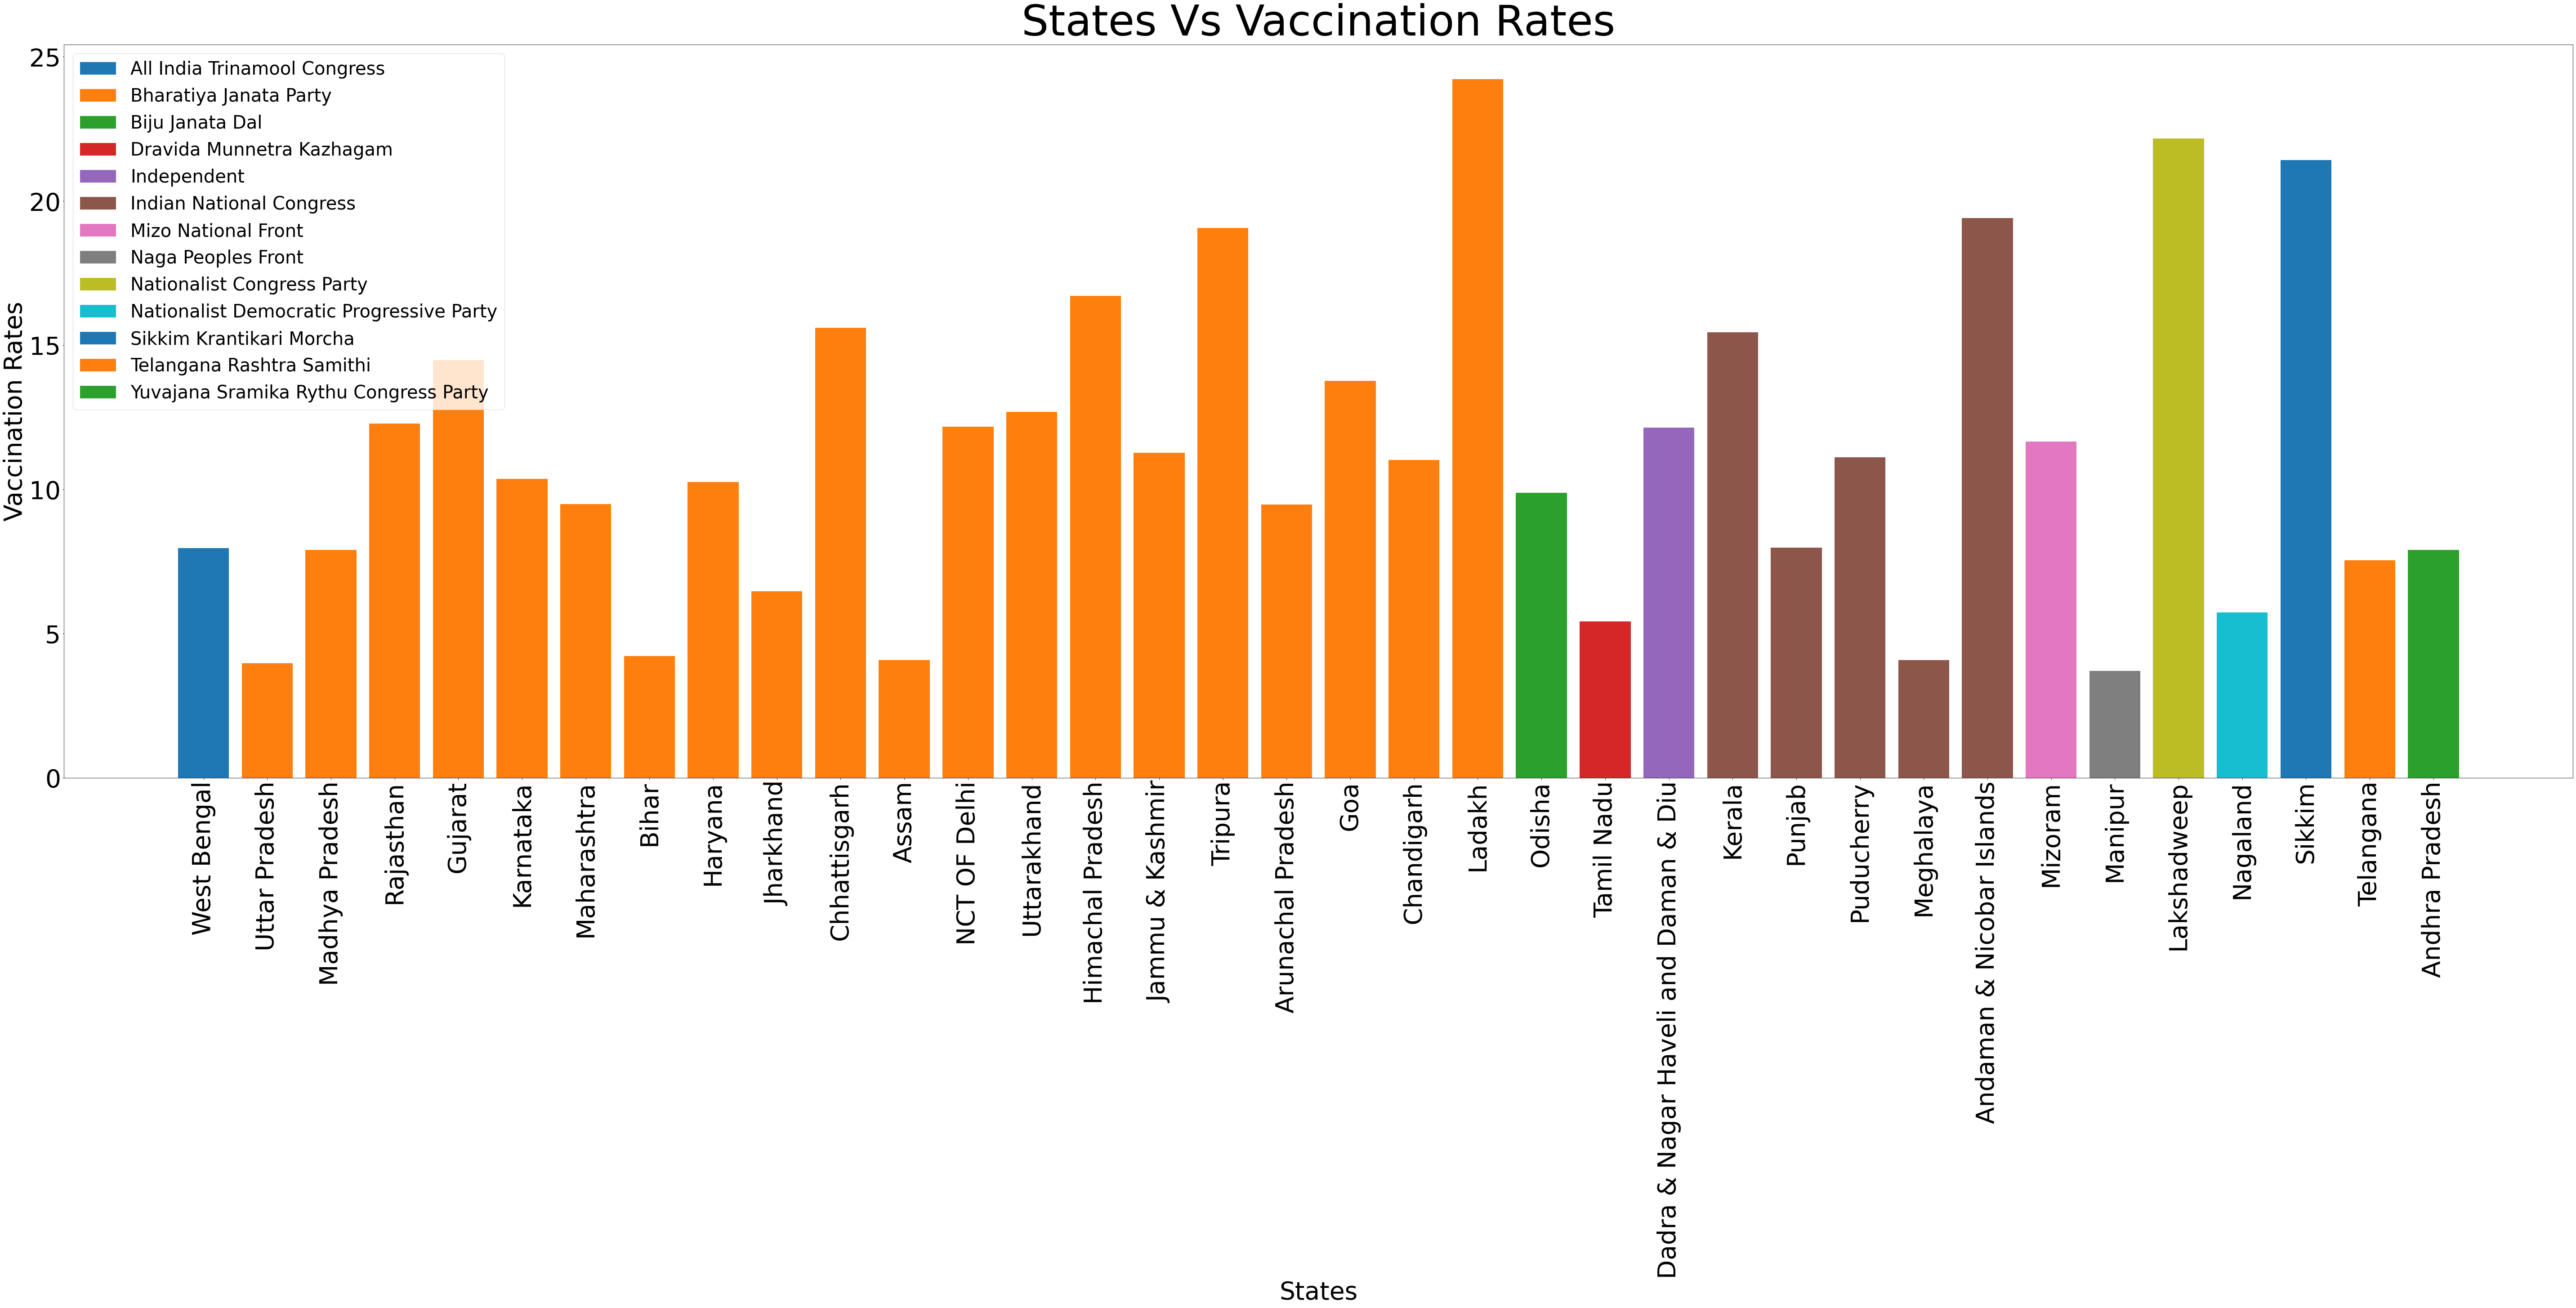

In [48]:
    #Cleaning all the file for Hypothesis 1
    stateElections = cleanData(stateElections)
    
    statePopulation = cleanData(statePopulation)
    
    #Performing analysis for Hypothesis 1
    stateGovt = hypothesis1(stateElections, stateVaccinations, statePopulation)

In [49]:
    #Loading all the input files for Hypothesis 2
    stateTesting = pd.read_csv("./statewise_tested_numbers_data.csv")
    
    #CLeaning all the files for Hypothesis 2
    stateTesting = cleanData(stateTesting)
    
    #Performing analysis for Hypothesis 2
    hypothesis2(stateTesting, stateVaccinations, stateGovt)

#########################################################################################################
                                            HYPOTHESIS 2                                                 
#########################################################################################################


In [50]:
    #Grouping all the data for Hypothesis 3
    groupedVaccineTypeData = getVaccineTypeCount(stateVaccinations)

    #Performing analysis for Hypothesis 3
    hypothesis3(groupedVaccineTypeData)

#########################################################################################################
                                            HYPOTHESIS 3                                                
#########################################################################################################
